# TP Final de Aprendizaje Profundo

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

## Importar librerías

In [30]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import confusion_matrix,recall_score
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers.legacy import Adadelta
from tensorflow.keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

## Cargar y visualizar el dataset

In [2]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (62, 47)
n_samples: 1288
n_classes: 7


In [3]:
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

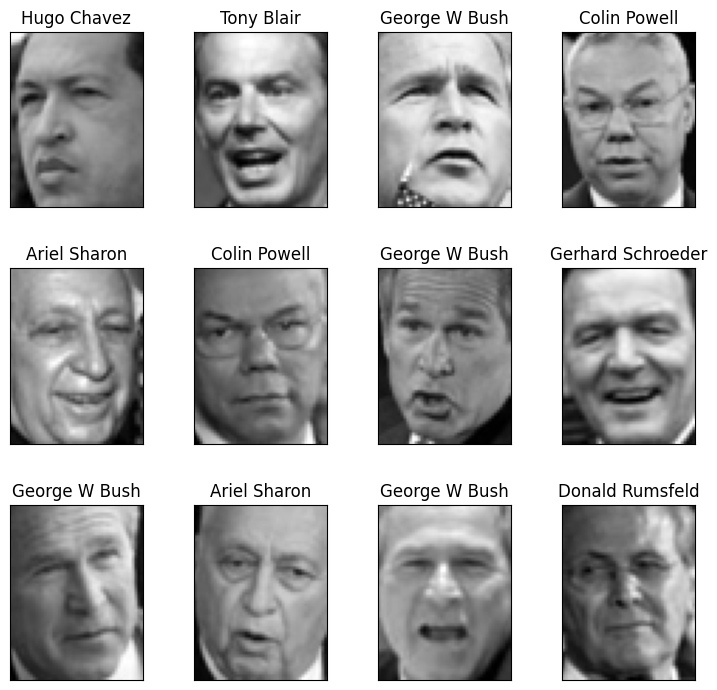

In [4]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

Voy a mirar los valores de X:

In [5]:
#Features: numeros reales, entre 0 y 255
print(X[0])

[[0.9973857  0.9973857  0.99607843 ... 0.26928106 0.23267974 0.20261438]
 [0.9973857  0.99607843 0.99477124 ... 0.275817   0.24052288 0.20915033]
 [0.9882353  0.97647065 0.96732026 ... 0.26928106 0.24052288 0.21830066]
 ...
 [0.3372549  0.2784314  0.20522876 ... 0.4117647  0.39869282 0.37908497]
 [0.30980393 0.2522876  0.19738562 ... 0.39607847 0.39607844 0.37254906]
 [0.28496733 0.24705882 0.19869281 ... 0.38431373 0.3869281  0.3803922 ]]


In [6]:
print(X.max())
print(X.min())

1.0
0.0


Los datos ya están normalizados, por lo que no va a ser necesario dividirlos por 255.

## Exploración de datos

<Axes: >

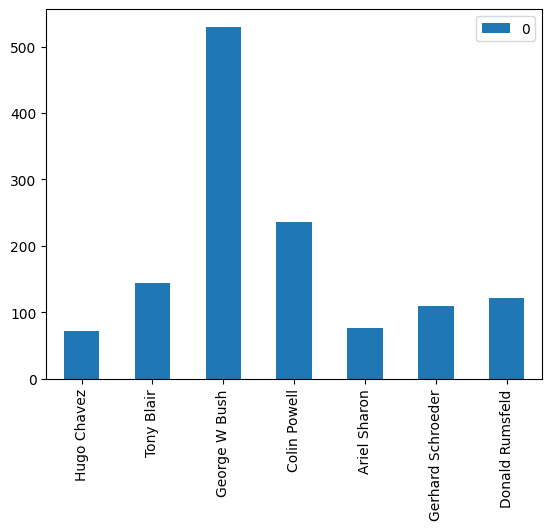

In [7]:
counts = Counter(y)
names = {}

for key in counts.keys():
    names[lfw_people.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

El dataset no está balanceado. La mayoría de las fotos corresponden a George W Bush, mientras que Ariel Sharon es el que está menos representado.

## Preparacion de los datos

Los siguientes pasos son:
* Separar en conjuntos de entrenamiento y evaluación
* Escalar los datos utilizando StandardScaler()
* Convertir las etiquetas en valores categóricos mediante One-Hot-Encoding.

In [8]:
#Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
n_classes = np.max(np.unique(y_train)) + 1

In [9]:
#Reshape para escalar
X_train = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
X_test = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))

In [10]:
#Escalado de datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#One-hot encoding de etiquetas
y_train = to_categorical(y_train, n_classes) 
y_test = to_categorical(y_test, n_classes) #one-hot encoding

## Modelo de Convolutional Neural Network (CNN)

El modelo incluirá dos capas convolucionales con activación ReLU. A estas les sigue una capa de max pooling y una de dropout para minimizar el sobreajuste. Los mapas de características se aplanarán antes de introducir una capa densa y otra de dropout. La capa de salida utilizará activación softmax para clasificar en varias clases. El modelo se compilará con un optimizador Adadelta, usando `categorical_crossentropy` como pérdida y midiendo la exactitud y el error cuadrático medio.

In [12]:
lr = 1.0
epochs = 15
batch_size = 64
np.random.seed(14)

Vuelvo a hacer el reshape para poder usar la red convolucional

In [13]:
# Las dimensiones serían (número de muestras, altura, anchura, canales)
X_train = X_train.reshape((-1, h, w, 1))

# Revertir el reshape para el conjunto de pruebas
X_test = X_test.reshape((-1, h, w, 1))

In [21]:
print(X_train.shape)
print(X_test.shape)

(966, 62, 47, 1)
(322, 62, 47, 1)


In [14]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=X_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), activation='relu') (input_layer)
conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1)
pool_1 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
dropout_1 = Dropout(0.25) (pool_1)
flatten_1 = Flatten() (dropout_1)
dense_1 = Dense(100, activation='relu') (flatten_1)
dropout_2 = Dropout(0.25) (dense_1)
output_layer = Dense(n_classes, activation='softmax') (dropout_2)
#---------------------------------------------------------------------#

model_conv = Model(input_layer, output_layer)
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model_conv.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 43, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 21, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 29, 21, 64)        0         
                                                                 
 flatten (Flatten)           (None, 38976)             0         
                                                             

In [15]:
start_time = time.time()
history_conv = model_conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/15
16/16 [==============================] - 4s 218ms/step - loss: 2.1957 - acc: 0.3240 - mse: 0.1209 - val_loss: 1.4815 - val_acc: 0.5559 - val_mse: 0.0949
Epoch 2/15
16/16 [==============================] - 4s 222ms/step - loss: 1.4499 - acc: 0.5041 - mse: 0.0948 - val_loss: 1.2920 - val_acc: 0.5870 - val_mse: 0.0808
Epoch 3/15
16/16 [==============================] - 3s 210ms/step - loss: 1.1673 - acc: 0.5870 - mse: 0.0771 - val_loss: 1.0971 - val_acc: 0.6273 - val_mse: 0.0726
Epoch 4/15
16/16 [==============================] - 3s 207ms/step - loss: 0.9939 - acc: 0.6439 - mse: 0.0680 - val_loss: 1.8348 - val_acc: 0.4161 - val_mse: 0.1230
Epoch 5/15
16/16 [==============================] - 3s 207ms/step - loss: 0.8742 - acc: 0.7039 - mse: 0.0599 - val_loss: 1.2225 - val_acc: 0.5373 - val_mse: 0.0844
Epoch 6/15
16/16 [==============================] - 3s 208ms/step - loss: 0.6156 - acc: 0.7961 - mse: 0.0429 - val_loss: 0.7777 - val_acc: 0.7640 - val_mse: 0.0494
Epoch 7/15
16/16

## Evaluación del modelo

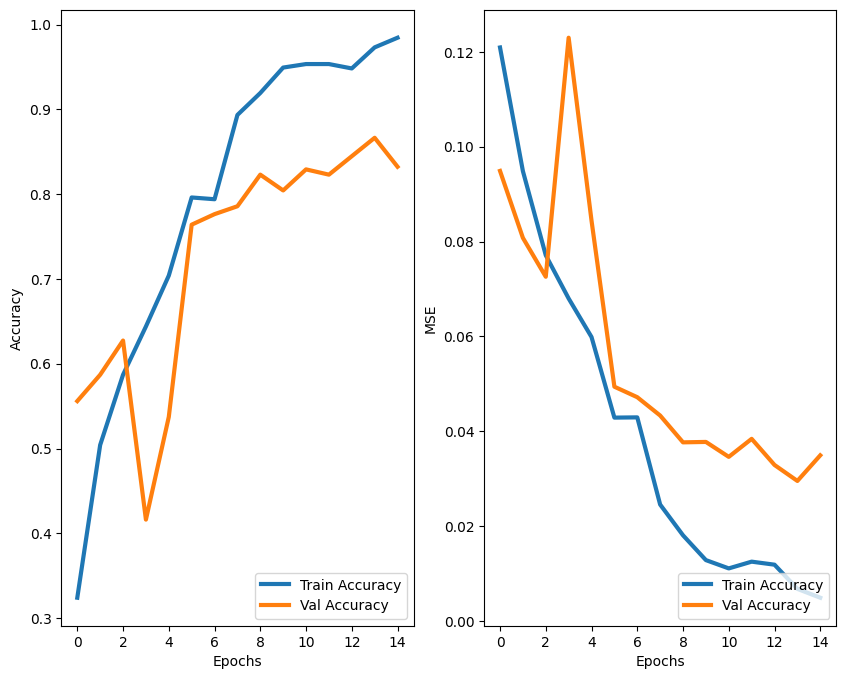

In [17]:
#Ploteo de resultados 
f = plt.figure(figsize=(10,8))

plt.subplot(1,2,1)

plt.plot(history_conv.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.axis([0, 10, 0, 1])
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_conv.history['mse'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_mse'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('MSE')
#plt.axis([0, 10, 0, 0.1])
plt.legend(loc='lower right')

plt.show()

In [23]:
# Matriz de confusion

#Predecir los valores en test
y_pred = model_conv.predict(X_test)

#Convertir las clases predichas a vectores one-hot
y_pred_classes = np.argmax(y_pred, axis=1) 
#Convertir las clases reales a vectores one-hot
y_true = np.argmax(y_test, axis=1) 

11/11 [==============================] - 0s 22ms/step


In [24]:
y_pred

array([[8.2993701e-09, 9.5905898e-07, 1.3630554e-05, ..., 7.8565012e-09,
        9.2995295e-10, 4.6400446e-06],
       [1.2428320e-02, 1.5179099e-01, 3.7822122e-04, ..., 2.7707287e-05,
        6.7982555e-06, 6.0802749e-06],
       [7.6822507e-06, 4.4921078e-04, 1.9577646e-04, ..., 1.9678201e-04,
        7.3099966e-07, 9.9866569e-01],
       ...,
       [2.3099578e-03, 2.1748978e-01, 5.7277173e-01, ..., 2.4277347e-03,
        5.5379796e-06, 1.5378824e-01],
       [7.9981663e-04, 7.5922206e-02, 1.4564548e-02, ..., 7.1100979e-03,
        1.7506860e-03, 2.8442370e-03],
       [1.0161218e-04, 8.5604768e-03, 7.7595705e-01, ..., 2.0372802e-03,
        1.7649045e-07, 2.0049824e-01]], dtype=float32)

In [25]:
y_pred_classes

array([3, 3, 6, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 1, 6,
       3, 0, 0, 1, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 4, 3, 3, 3, 0, 3, 6, 2, 1, 3, 3, 3, 1, 1, 0, 4, 0, 3,
       6, 4, 1, 3, 1, 6, 3, 3, 3, 2, 1, 6, 6, 6, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 6, 1, 6, 1, 1, 6, 6, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1,
       4, 1, 4, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 3, 6, 6,
       6, 3, 2, 6, 3, 3, 1, 6, 2, 2, 3, 1, 3, 6, 1, 3, 6, 1, 1, 1, 1, 3,
       3, 3, 6, 0, 1, 1, 6, 3, 5, 1, 3, 1, 5, 1, 2, 3, 1, 1, 6, 1, 3, 6,
       3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 6, 3, 3, 6,
       3, 6, 3, 2, 1, 2, 3, 1, 6, 2, 1, 2, 3, 4, 3, 3, 3, 3, 3, 2, 3, 1,
       2, 3, 1, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 1,
       2, 4, 3, 0, 3, 3, 3, 4, 4, 3, 4, 1, 3, 4, 2, 1, 6, 2, 3, 3, 6, 1,
       3, 6, 6, 1, 3, 6, 1, 1, 3, 3, 6, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0,
       3, 3, 3, 4, 3, 3, 5, 3, 3, 1, 4, 3, 3, 6, 3,

In [26]:
y_true

array([3, 3, 6, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 4, 1, 2,
       3, 2, 0, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 2, 3, 3, 3, 0, 3, 6, 2, 1, 3, 5, 3, 1, 1, 1, 4, 3, 5,
       6, 4, 1, 3, 5, 6, 3, 3, 3, 2, 1, 6, 4, 4, 3, 0, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 4, 1, 5, 1, 1, 6, 6, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1,
       4, 1, 3, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 1, 6, 6,
       6, 6, 2, 4, 3, 3, 1, 6, 2, 2, 5, 1, 3, 5, 1, 3, 6, 1, 5, 1, 1, 3,
       3, 3, 6, 0, 1, 3, 6, 5, 5, 1, 3, 5, 5, 1, 0, 3, 1, 1, 6, 1, 5, 6,
       3, 2, 2, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 6, 3, 3, 6,
       3, 6, 3, 2, 1, 2, 3, 3, 6, 2, 1, 0, 3, 5, 3, 3, 3, 3, 3, 0, 0, 1,
       3, 3, 1, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 4,
       2, 4, 3, 0, 3, 3, 3, 6, 4, 3, 2, 6, 3, 4, 2, 1, 6, 2, 2, 3, 6, 1,
       3, 4, 3, 1, 4, 6, 1, 1, 3, 3, 6, 3, 6, 3, 3, 3, 1, 2, 3, 3, 1, 0,
       3, 3, 3, 4, 4, 3, 5, 1, 3, 0, 4, 1, 3, 4, 3,

Voy a plotear una matriz de confusión para visualizar qué tan bien el modelo reconoce las caras.

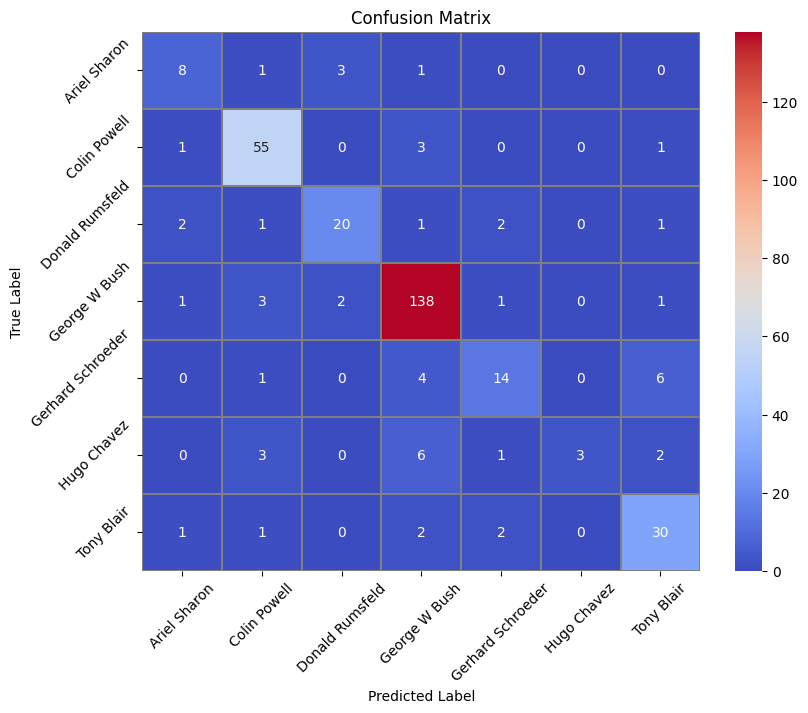

In [37]:
#Matriz de confusion
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="coolwarm", linecolor="gray", fmt='d', ax=ax,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Este modelo al que peor clasifica es a Hugo Chávez, identificándolo de forma correcta 3/15 veces (20%). 
Al que mejor clasifica es a GW Bush, identificándolo de forma correcta  138/146 veces (94,5%).